In [1]:
import pandas as pd
import sqlite3


#SQL 


In [2]:
def pd_to_sqlDB(input_df: pd.DataFrame,
                table_name: str,
                db_name: str = 'default.db') -> None:

    '''Take a Pandas dataframe `input_df` and upload it to `table_name` SQLITE table

    Args:
        input_df (pd.DataFrame): Dataframe containing data to upload to SQLITE
        table_name (str): Name of the SQLITE table to upload to
        db_name (str, optional): Name of the SQLITE Database in which the table is created. 
                                 Defaults to 'default.db'.
    '''

    # Step 1: Setup local logging
    import logging
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s %(levelname)s: %(message)s',
                        datefmt='%Y-%m-%d %H:%M:%S')

    # Step 2: Find columns in the dataframe
    cols = input_df.columns
    cols_string = ','.join(cols)
    val_wildcard_string = ','.join(['?'] * len(cols))

    # Step 3: Connect to a DB file if it exists, else crete a new file
    con = sqlite3.connect(db_name)
    cur = con.cursor()
    logging.info(f'SQL DB {db_name} created')

    # Step 4: Create Table
    sql_string = f"""CREATE TABLE {table_name} ({cols_string});"""
    cur.execute(sql_string)
    logging.info(f'SQL Table {table_name} created with {len(cols)} columns')

    # Step 5: Upload the dataframe
    rows_to_upload = input_df.to_dict(orient='split')['data']
    sql_string = f"""INSERT INTO {table_name} ({cols_string}) VALUES ({val_wildcard_string});"""
    cur.executemany(sql_string, rows_to_upload)
    logging.info(f'{len(rows_to_upload)} rows uploaded to {table_name}')
  
    # Step 6: Commit the changes and close the connection
    con.commit()
    con.close()


def sql_query_to_pd(sql_query_string: str, db_name: str ='default.db') -> pd.DataFrame:
    '''Execute an SQL query and return the results as a pandas dataframe

    Args:
        sql_query_string (str): SQL query string to execute
        db_name (str, optional): Name of the SQLITE Database to execute the query in.
                                 Defaults to 'default.db'.

    Returns:
        pd.DataFrame: Results of the SQL query in a pandas dataframe
    '''    
    # Step 1: Connect to the SQL DB
    con = sqlite3.connect(db_name)

    # Step 2: Execute the SQL query
    cursor = con.execute(sql_query_string)

    # Step 3: Fetch the data and column names
    result_data = cursor.fetchall()
    cols = [description[0] for description in cursor.description]

    # Step 4: Close the connection
    con.close()

    # Step 5: Return as a dataframe
    return pd.DataFrame(result_data, columns=cols)

#Data and query


In [8]:
# Step 1: Read the csv file into a dataframe
# Dataset from https://earthquake.usgs.gov/earthquakes/
input_df = pd.read_csv('query.csv')


In [9]:
input_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-11-16T14:23:30.763Z,-20.6803,-177.6475,466.540,4.5,mb,110.0,70.0,2.336,1.00,...,2022-11-16T14:49:46.040Z,NaN,earthquake,11.55,7.563,0.046,146.0,reviewed,us,us
1,2022-11-16T13:47:44.447Z,47.2851,-114.1267,11.888,3.7,mwr,41.0,50.0,0.474,0.82,...,2022-11-16T16:00:36.897Z,"4 km ENE of Ravalli, Montana",earthquake,4.96,6.818,0.047,43.0,reviewed,us,us
2,2022-11-16T10:53:27.646Z,6.0962,-82.4965,10.000,4.4,mb,23.0,166.0,2.687,1.02,...,2022-11-16T11:11:33.040Z,"218 km S of Burica, Panama",earthquake,9.11,1.954,0.162,11.0,reviewed,us,us
3,2022-11-16T09:50:21.891Z,-60.6750,-29.3781,10.000,4.7,mb,22.0,88.0,14.031,0.60,...,2022-11-16T10:15:58.040Z,South Sandwich Islands region,earthquake,9.74,1.857,0.120,21.0,reviewed,us,us
4,2022-11-16T09:22:44.754Z,-5.3468,102.3553,32.340,5.1,mb,58.0,93.0,1.148,0.71,...,2022-11-16T09:40:00.040Z,"171 km S of Bengkulu, Indonesia",earthquake,7.13,4.364,0.080,50.0,reviewed,us,us
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,2022-11-09T01:15:09.397Z,-4.2204,-80.5016,42.705,5.1,mww,48.0,136.0,8.501,0.50,...,2022-11-10T03:42:51.983Z,"30 km ESE of Papayal, Peru",earthquake,9.83,5.061,0.098,10.0,reviewed,us,us
189,2022-11-09T00:57:14.321Z,29.9803,80.2903,22.974,4.4,mb,22.0,166.0,4.884,0.63,...,2022-11-16T04:45:21.934Z,"26 km WNW of Dh?rchula, India",earthquake,9.97,6.418,0.117,21.0,reviewed,us,us
190,2022-11-09T00:33:00.770Z,-59.8027,-25.4765,10.000,4.4,mb,10.0,143.0,8.157,0.82,...,2022-11-16T04:33:35.040Z,South Sandwich Islands region,earthquake,12.58,1.969,0.149,13.0,reviewed,us,us
191,2022-11-09T00:27:46.354Z,11.1924,126.4496,10.000,4.6,mb,49.0,127.0,4.186,0.60,...,2022-11-16T04:04:06.040Z,"73 km ENE of Sulangan, Philippines",earthquake,6.79,1.836,0.085,42.0,reviewed,us,us


In [54]:
 
# Step 2: Upload the dataframe to a SQL Table
pd_to_sqlDB(input_df,
            table_name='earthquakes_weekly_nov_2022',
            db_name='default.db')
 
# Step 3: Write the SQL query in a string variable
sql_query_string = """
    SELECT mag as MAGNITUDE, place, time, latitude, longitude
    FROM earthquakes
    WHERE place IS NOT NULL 
    ORDER BY mag DESC
"""
 
# Step 4: Exectue the SQL query
result_df = sql_query_to_pd(sql_query_string, db_name='default.db')
result_df

,MAGNITUDE,place,time,latitude,longitude
0,7.30,"211 km ESE of Neiafu, Tonga",2022-11-11T10:48:45.102Z,-19.3181,-172.1001
1,7.00,Fiji region,2022-11-12T07:09:14.046Z,-20.1155,-178.3627
2,7.00,south of the Fiji Islands,2022-11-09T09:51:04.520Z,-26.0442,178.3808
3,6.80,south of the Fiji Islands,2022-11-09T09:38:42.801Z,-25.9678,178.3625
4,6.70,south of the Fiji Islands,2022-11-09T09:38:41.000Z,-26.0370,178.5790
...,...,...,...,...,...
182,3.79,"34 km SE of Boca de Yuma, Dominican Republic",2022-11-14T02:21:03.310Z,18.1220,-68.4255
183,3.78,"44 km S of Boca de Yuma, Dominican Republic",2022-11-12T09:32:29.530Z,17.9780,-68.5411
184,3.76,"140 km N of Charlotte Amalie, U.S. Virgin Islands",2022-11-15T23:30:51.300Z,19.6035,-64.7556
185,3.70,"4 km ENE of Ravalli, Montana",2022-11-16T13:47:44.447Z,47.2851,-114.1267


##Data Visualisation

In [17]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 16.7 MB 40.7 MB/s 
     |████████████████████████████████| 6.3 MB 3.3 MB/s 


In [18]:
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, polygon

%matplotlib inline 

In [55]:
geometry = [Point(xy) for xy in zip( result_df['longitude'], result_df['latitude'])] #transforming in points the coordinates

In [56]:
geometry[:3]

In [57]:
geo_df = gpd.GeoDataFrame ( result_df,
                           )

In [58]:
geo_df.head()

,MAGNITUDE,place,time,latitude,longitude
0,7.3,"211 km ESE of Neiafu, Tonga",2022-11-11T10:48:45.102Z,-19.3181,-172.1001
1,7.0,Fiji region,2022-11-12T07:09:14.046Z,-20.1155,-178.3627
2,7.0,south of the Fiji Islands,2022-11-09T09:51:04.520Z,-26.0442,178.3808
3,6.8,south of the Fiji Islands,2022-11-09T09:38:42.801Z,-25.9678,178.3625
4,6.7,south of the Fiji Islands,2022-11-09T09:38:41.000Z,-26.0370,178.5790


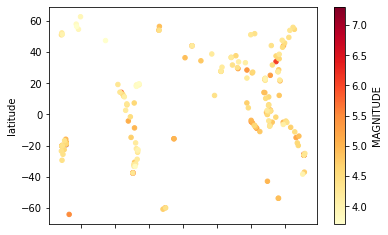

In [60]:
result_df.plot(x='longitude', y='latitude', kind='scatter', c='MAGNITUDE', colormap="YlOrRd") #plotting the map without adding the world

In [61]:
countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


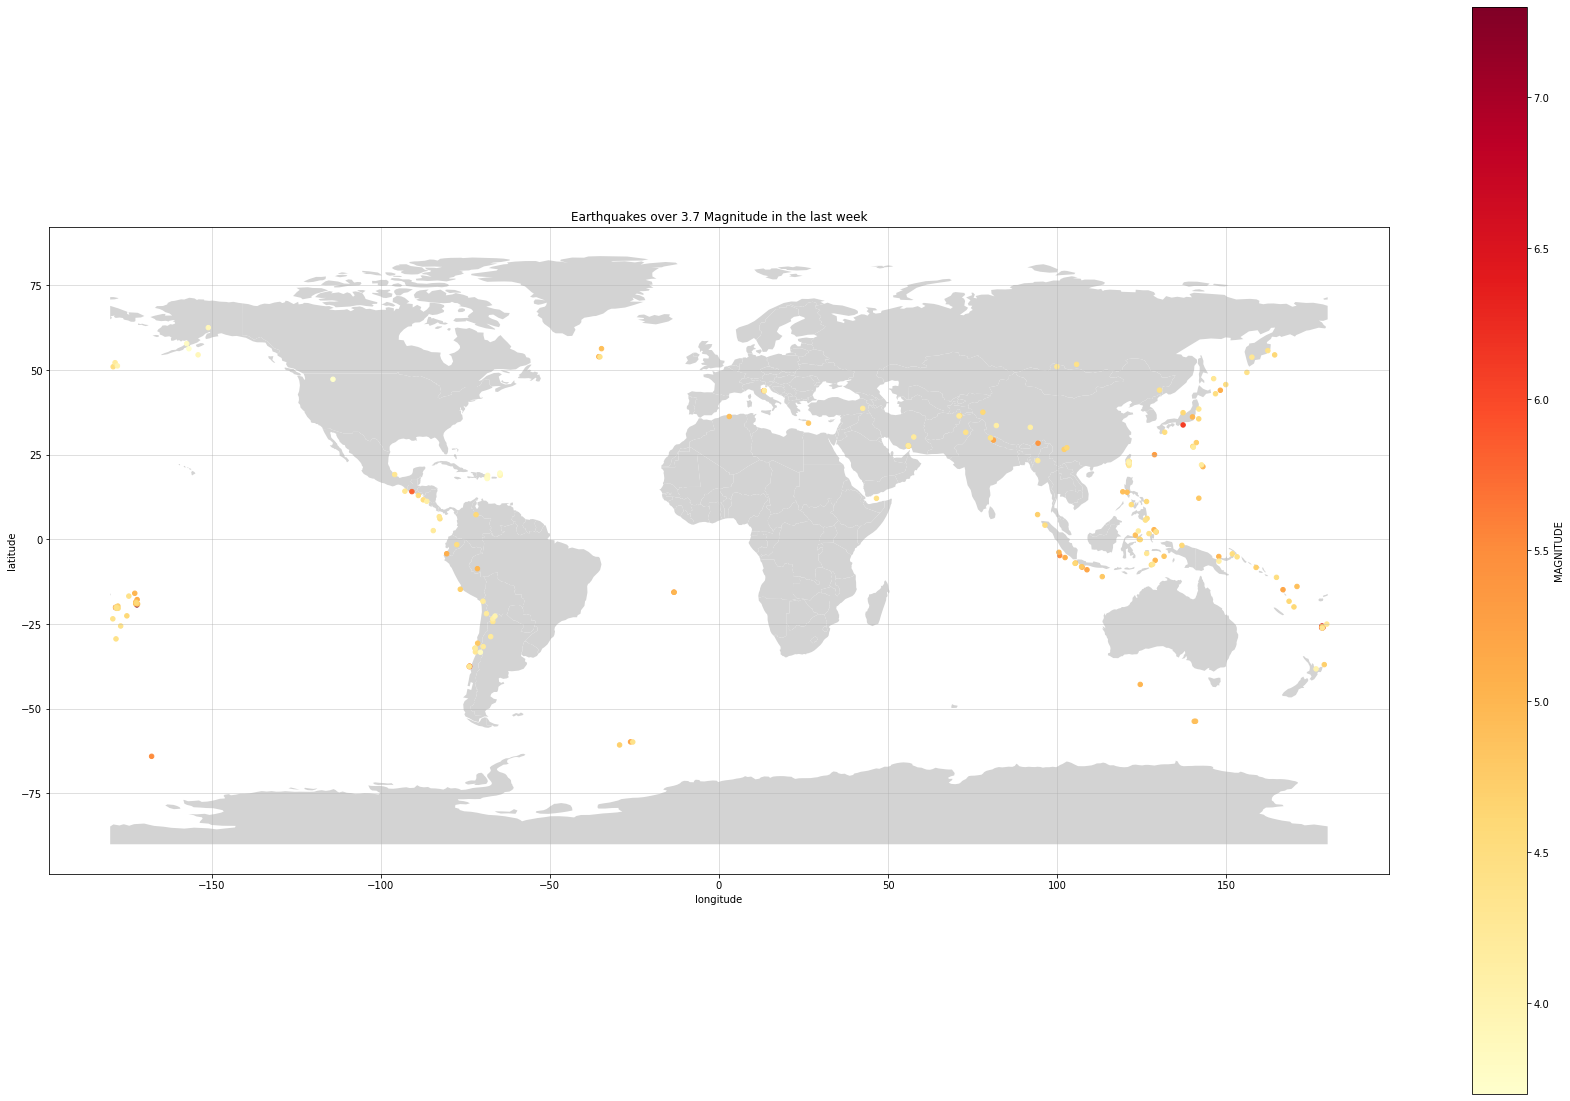

In [96]:
# initialize an axis
fig, ax = plt.subplots(figsize=(30,20))
# plot map on axis
countries = gpd.read_file(  
     gpd.datasets.get_path("naturalearth_lowres"))

countries.plot(color="lightgrey", ax=ax)
# plot points
result_df.plot(x="longitude", y="latitude", kind="scatter", c='MAGNITUDE', colormap="YlOrRd",
               title="Earthquakes over 3.7 Magnitude in the last week" , ax=ax)
# add grid
ax.grid(b=True, alpha=0.5)
plt.show()